# Predictive Modeling of Peak Oil Production Rates in Unconventional Wells
## Introduction

In this challenge, we focus on developing predictive models for estimating peak oil production rates in unconventional wells, particularly in areas like the Permian Basin and Haynesville Shale. Our objective is to aid asset development teams in forecasting well performance before they become operational.

Key steps in our approach include:

1. **Data Exploration and Preparation**: Analyzing historical production data to understand well behavior.
2. **Feature Engineering**: Crafting features that influence peak production rates.
3. **Model Development**: Implementing machine learning algorithms to predict peak production rates.
4. **Validation and Testing**: Ensuring model reliability on new data.
5. **Insights and Implications**: Interpreting results for strategic asset development.

The aim is to create a robust tool for data-driven decision-making in oil and gas asset management, enhancing efficiency and resource optimization.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, DistanceMetric
from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2, mutual_info_regression
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Import Data

In [2]:
df = pd.read_csv('dataset/training.csv')
df.head()

,Unnamed: 0,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,number_of_stages,total_proppant,total_fluid,...,relative_well_position,batch_frac_classification,well_family_relationship,frac_type,frac_seasoning,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,OilPeakRate
0,0,1383493.751,717329.2368,1382854.564,712767.3700,1121,3963.582677,NaN,76000.0000,NaN,...,Standalone Well,Unknown,Standalone Well,Primary Frac,NaN,1383030.678,714796.3610,1382668.912,712798.4321,46.623023
1,1,1380344.035,711916.2732,1379738.429,707860.5643,1022,3179.133858,NaN,113000.0000,5.610964e+05,...,Outer Well,Unknown,Infill Child Well,Primary Frac,NaN,1379965.126,709541.7145,1379630.025,707907.6708,59.750009
2,2,1379915.895,717845.0063,1379274.644,713471.9952,1304,3810.039370,12.0,286571.4286,1.621424e+06,...,Standalone Well,Non-Batch Frac,Standalone Well,Primary Frac,92.0,1379357.250,715381.2327,1378960.372,713530.4490,10.785716
3,3,1383567.443,706640.2010,1382891.477,702068.3838,1022,3723.425197,11.0,106878.9286,4.377134e+05,...,Standalone Well,Unknown,Standalone Well,Primary Frac,NaN,1383099.610,704058.8508,1382727.299,702098.4882,123.797638
4,4,1378962.585,702623.9787,1379643.546,707204.9131,1022,3811.023622,NaN,112789.7143,6.229802e+05,...,Outer Well,Unknown,Infill Child Well,Primary Frac,NaN,1379546.414,705150.7519,1379987.487,707123.7258,102.309540


In [3]:
df.shape

(29692, 31)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29692 entries, 0 to 29691
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    29692 non-null  int64  
 1   surface_x                     29692 non-null  float64
 2   surface_y                     29692 non-null  float64
 3   bh_x                          27605 non-null  float64
 4   bh_y                          27605 non-null  float64
 5   standardized_operator_name    29692 non-null  int64  
 6   gross_perforated_length       22135 non-null  float64
 7   number_of_stages              2752 non-null   float64
 8   total_proppant                19080 non-null  float64
 9   total_fluid                   19076 non-null  float64
 10  true_vertical_depth           28197 non-null  float64
 11  ffs_frac_type                 14585 non-null  object 
 12  proppant_intensity            18971 non-null  float64
 13  f

In [5]:
df.describe()

,Unnamed: 0,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,number_of_stages,total_proppant,total_fluid,...,proppant_to_frac_fluid_ratio,frac_fluid_to_proppant_ratio,bin_lateral_length,pad_id,frac_seasoning,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,OilPeakRate
count,29692.000000,2.969200e+04,2.969200e+04,2.760500e+04,2.760500e+04,29692.000000,22135.000000,2752.000000,1.908000e+04,1.907600e+04,...,18656.000000,1.865600e+04,22135.000000,29692.000000,14768.000000,2.869100e+04,2.869100e+04,2.898100e+04,2.898100e+04,19306.000000
mean,14847.414051,1.020863e+06,1.075477e+06,1.020478e+06,1.079357e+06,1157.264347,6533.676565,28.240552,7.624826e+05,4.020891e+06,...,0.231901,inf,1.380596,109024.135828,49.523158,1.020062e+06,1.078012e+06,1.020469e+06,1.076462e+06,219.854511
std,8574.811270,1.721561e+05,3.156502e+05,1.702888e+05,3.162917e+05,107.281214,2504.368680,13.612821,8.122641e+05,2.721153e+06,...,1.166795,NaN,0.481280,5196.020035,63.104234,1.703143e+05,3.155907e+05,1.713936e+05,3.155836e+05,155.790160
min,0.000000,5.357005e+05,4.951165e+05,5.323590e+05,4.957629e+05,1001.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000,7.830841e-03,0.000000,100001.000000,0.000000,5.400136e+05,4.961486e+05,5.323590e+05,4.957629e+05,0.011905
25%,7422.750000,8.903506e+05,8.043973e+05,8.911762e+05,8.061600e+05,1060.000000,4341.535433,17.000000,3.642857e+05,1.871676e+06,...,0.162421,4.268300e+00,1.000000,104516.000000,24.000000,8.914115e+05,8.051170e+05,8.908974e+05,8.046434e+05,107.918152
50%,14845.500000,1.019947e+06,9.893755e+05,1.017596e+06,1.000664e+06,1144.000000,6684.055118,27.000000,7.013834e+05,3.564951e+06,...,0.194734,5.135199e+00,1.500000,109018.500000,38.000000,1.018147e+06,9.986236e+05,1.017865e+06,9.938718e+05,192.767887
75%,22268.250000,1.133213e+06,1.366018e+06,1.132495e+06,1.369018e+06,1231.000000,8899.114173,38.000000,1.087321e+06,5.843925e+06,...,0.234285,6.156844e+00,2.000000,113492.000000,60.000000,1.132536e+06,1.367010e+06,1.132084e+06,1.366495e+06,298.073218
max,30091.000000,1.728209e+06,1.811475e+06,1.729432e+06,1.811882e+06,1354.000000,15744.094490,70.000000,9.109073e+07,3.442402e+07,...,127.700206,inf,3.000000,117976.000000,4827.000000,1.728874e+06,1.811592e+06,1.729656e+06,1.811770e+06,2855.469490


## Data Cleaning

In [6]:
df.dropna(subset=['OilPeakRate'], inplace=True)
df.drop(['Unnamed: 0', 'pad_id', 'standardized_operator_name', 'frac_type'], axis=1, inplace=True)

In [7]:
# Drop rows with missing values
df.dropna(inplace=True)

In [8]:
df.describe()

,surface_x,surface_y,bh_x,bh_y,gross_perforated_length,number_of_stages,total_proppant,total_fluid,true_vertical_depth,proppant_intensity,...,average_frac_fluid_per_stage,proppant_to_frac_fluid_ratio,frac_fluid_to_proppant_ratio,bin_lateral_length,frac_seasoning,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,OilPeakRate
count,1.983000e+03,1.983000e+03,1.983000e+03,1.983000e+03,1983.000000,1983.000000,1.983000e+03,1.983000e+03,1983.000000,1983.000000,...,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1.983000e+03,1.983000e+03,1.983000e+03,1.983000e+03,1983.000000
mean,9.659894e+05,1.172593e+06,9.663066e+05,1.172432e+06,6388.115021,28.739788,6.634347e+05,3.372470e+06,8263.638566,99.449718,...,113720.315828,0.206925,5.452839,1.358296,50.517902,9.661610e+05,1.172505e+06,9.663019e+05,1.172430e+06,184.311208
std,1.526118e+05,3.566799e+05,1.525667e+05,3.564460e+05,2097.287006,13.066772,4.030238e+05,2.128575e+06,1828.670085,44.544372,...,41855.918520,0.072687,3.109200,0.393041,41.486501,1.525458e+05,3.565537e+05,1.525671e+05,3.564474e+05,130.878111
min,6.309095e+05,5.511906e+05,6.330213e+05,5.518347e+05,1136.811024,3.000000,1.422857e+03,2.145163e+04,2818.897638,0.421587,...,1430.108951,0.014196,0.667970,0.000000,0.000000,6.338535e+05,5.516831e+05,6.330235e+05,5.521509e+05,0.430556
25%,8.165262e+05,8.088458e+05,8.214843e+05,8.089644e+05,4392.716535,19.000000,3.827313e+05,1.928312e+06,6881.889764,71.510878,...,86378.123400,0.170563,4.304857,1.000000,26.000000,8.193051e+05,8.090177e+05,8.215293e+05,8.088567e+05,83.549333
50%,9.734531e+05,1.236962e+06,9.713567e+05,1.238601e+06,6719.488189,28.000000,6.140491e+05,3.074232e+06,8556.102362,95.938182,...,110425.235900,0.198422,5.039754,1.500000,39.000000,9.730340e+05,1.237191e+06,9.712851e+05,1.238187e+06,149.500023
75%,1.053916e+06,1.498222e+06,1.058633e+06,1.498523e+06,7699.311024,37.000000,8.750872e+05,4.282250e+06,9445.374016,122.759534,...,138343.931450,0.232296,5.862951,1.500000,60.000000,1.054724e+06,1.497986e+06,1.058684e+06,1.498523e+06,260.526197
max,1.448480e+06,1.726318e+06,1.449082e+06,1.727185e+06,11129.921260,70.000000,2.411429e+06,1.387900e+07,12860.236220,347.559473,...,338512.167400,1.497074,70.443998,2.500000,380.000000,1.448738e+06,1.726838e+06,1.448884e+06,1.727185e+06,914.892999


In [9]:
df.isnull().sum()

surface_x                       0
surface_y                       0
bh_x                            0
bh_y                            0
gross_perforated_length         0
number_of_stages                0
total_proppant                  0
total_fluid                     0
true_vertical_depth             0
ffs_frac_type                   0
proppant_intensity              0
frac_fluid_intensity            0
average_stage_length            0
average_proppant_per_stage      0
average_frac_fluid_per_stage    0
proppant_to_frac_fluid_ratio    0
frac_fluid_to_proppant_ratio    0
bin_lateral_length              0
relative_well_position          0
batch_frac_classification       0
well_family_relationship        0
frac_seasoning                  0
horizontal_midpoint_x           0
horizontal_midpoint_y           0
horizontal_toe_x                0
horizontal_toe_y                0
OilPeakRate                     0
dtype: int64

# Exploratory Data Analysis

In [10]:
X = df.drop("OilPeakRate", axis=1)
Y = df["OilPeakRate"]

In [11]:
plt.figure(figsize=(10, 6))

def linearRegressionPlot(x):
    model = LinearRegression()
    model.fit(x.values.reshape(-1, 1), Y)

    slope = model.coef_[0]
    intercept = model.intercept_

    plt.scatter(x, Y, s=4, color="y")

    x_range = np.linspace(min(x), max(x), 100)
    y_range = slope * x_range + intercept
    plt.plot(x_range, y_range, color='red', label='linear regression line')
    plt.xlabel('true_vertical_depth')
    plt.ylabel('OilPeakRate')
    plt.legend()

    plt.show()

<Figure size 720x432 with 0 Axes>

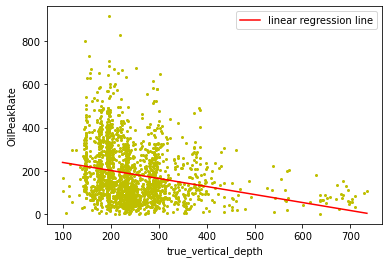

In [12]:
linearRegressionPlot(X["average_stage_length"])

The linear regression line indicates that there is a positive relationship between "average_stage_length" and "OilPeakRate". The peak oil production rate increases with the average stage length. This may mean that longer fracturing stages may be associated with more efficient oil recovery, leading to higher production rates.

In [13]:
from mpl_toolkits.mplot3d import Axes3D
def linearRegressionPlot3D(x1, x2, xlabel, ylabel):
    x = x1
    y = x2
    z = Y

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    scat = ax.scatter(x, y, z)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel('OilPeakRate')
    plt.show()

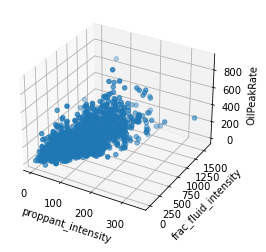

In [14]:
linearRegressionPlot3D(X["proppant_intensity"], X["frac_fluid_intensity"], 'proppant_intensity', 'frac_fluid_intensity')

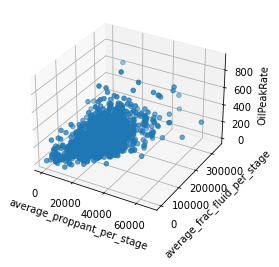

In [15]:
linearRegressionPlot3D(X["average_proppant_per_stage"], X["average_frac_fluid_per_stage"], 'average_proppant_per_stage', 'average_frac_fluid_per_stage')

The concentration of points along the bottom of the plot shows that the "OilPeakRate" is low regardless of the amount of proppant or frac fluid per stage (average), indicating that other factors may have a more significant impact on peak oil rate production rate.

## Confusion Matrix

In [16]:
dist = DistanceMetric.get_metric('euclidean')

correlation_matrix = X.corr()
correlation_matrix 

,surface_x,surface_y,bh_x,bh_y,gross_perforated_length,number_of_stages,total_proppant,total_fluid,true_vertical_depth,proppant_intensity,...,average_proppant_per_stage,average_frac_fluid_per_stage,proppant_to_frac_fluid_ratio,frac_fluid_to_proppant_ratio,bin_lateral_length,frac_seasoning,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y
surface_x,1.000000,-0.556427,0.998929,-0.556422,-0.257690,-0.198434,-0.184907,-0.125462,0.280263,-0.118670,...,-0.091500,-0.012369,-0.077720,0.095660,-0.194172,0.063845,0.999682,-0.556418,0.998923,-0.556435
surface_y,-0.556427,1.000000,-0.551220,0.999978,0.353912,0.268780,0.076230,0.078201,-0.479922,-0.128281,...,-0.190286,-0.129531,-0.048876,0.005492,0.275988,-0.105539,-0.553801,0.999993,-0.551302,0.999978
bh_x,0.998929,-0.551220,1.000000,-0.551432,-0.254848,-0.195029,-0.185725,-0.124207,0.278381,-0.122099,...,-0.096607,-0.015036,-0.080228,0.095456,-0.191508,0.063983,0.999773,-0.551328,0.999993,-0.551447
bh_y,-0.556422,0.999978,-0.551432,1.000000,0.353194,0.267912,0.075787,0.077370,-0.480040,-0.128272,...,-0.189934,-0.129575,-0.048522,0.005205,0.275258,-0.106086,-0.553913,0.999995,-0.551514,0.999999
gross_perforated_length,-0.257690,0.353912,-0.254848,0.353194,1.000000,0.832947,0.744775,0.727515,0.012897,0.301349,...,0.233375,0.221356,-0.015121,-0.044156,0.961156,0.134792,-0.256225,0.353530,-0.254773,0.353198
number_of_stages,-0.198434,0.268780,-0.195029,0.267912,0.832947,1.000000,0.830789,0.813492,0.163411,0.537013,...,0.206542,0.190566,-0.018871,-0.066184,0.793379,0.201975,-0.196668,0.268313,-0.194977,0.267907
total_proppant,-0.184907,0.076230,-0.185725,0.075787,0.744775,0.830789,1.000000,0.903109,0.271383,0.817504,...,0.654442,0.502992,0.086210,-0.195723,0.715614,0.267259,-0.185370,0.075972,-0.185635,0.075782
total_fluid,-0.125462,0.078201,-0.124207,0.077370,0.727515,0.813492,0.903109,1.000000,0.305232,0.694761,...,0.506141,0.661234,-0.222538,0.062969,0.702657,0.271206,-0.124832,0.077741,-0.124185,0.077363
true_vertical_depth,0.280263,-0.479922,0.278381,-0.480040,0.012897,0.163411,0.271383,0.305232,1.000000,0.421084,...,0.337216,0.388994,-0.083966,0.012667,0.045780,0.138582,0.279313,-0.479981,0.278437,-0.480045
proppant_intensity,-0.118670,-0.128281,-0.122099,-0.128272,0.301349,0.537013,0.817504,0.694761,0.421084,1.000000,...,0.827727,0.602755,0.146472,-0.263610,0.285788,0.227724,-0.120499,-0.128306,-0.121974,-0.128279


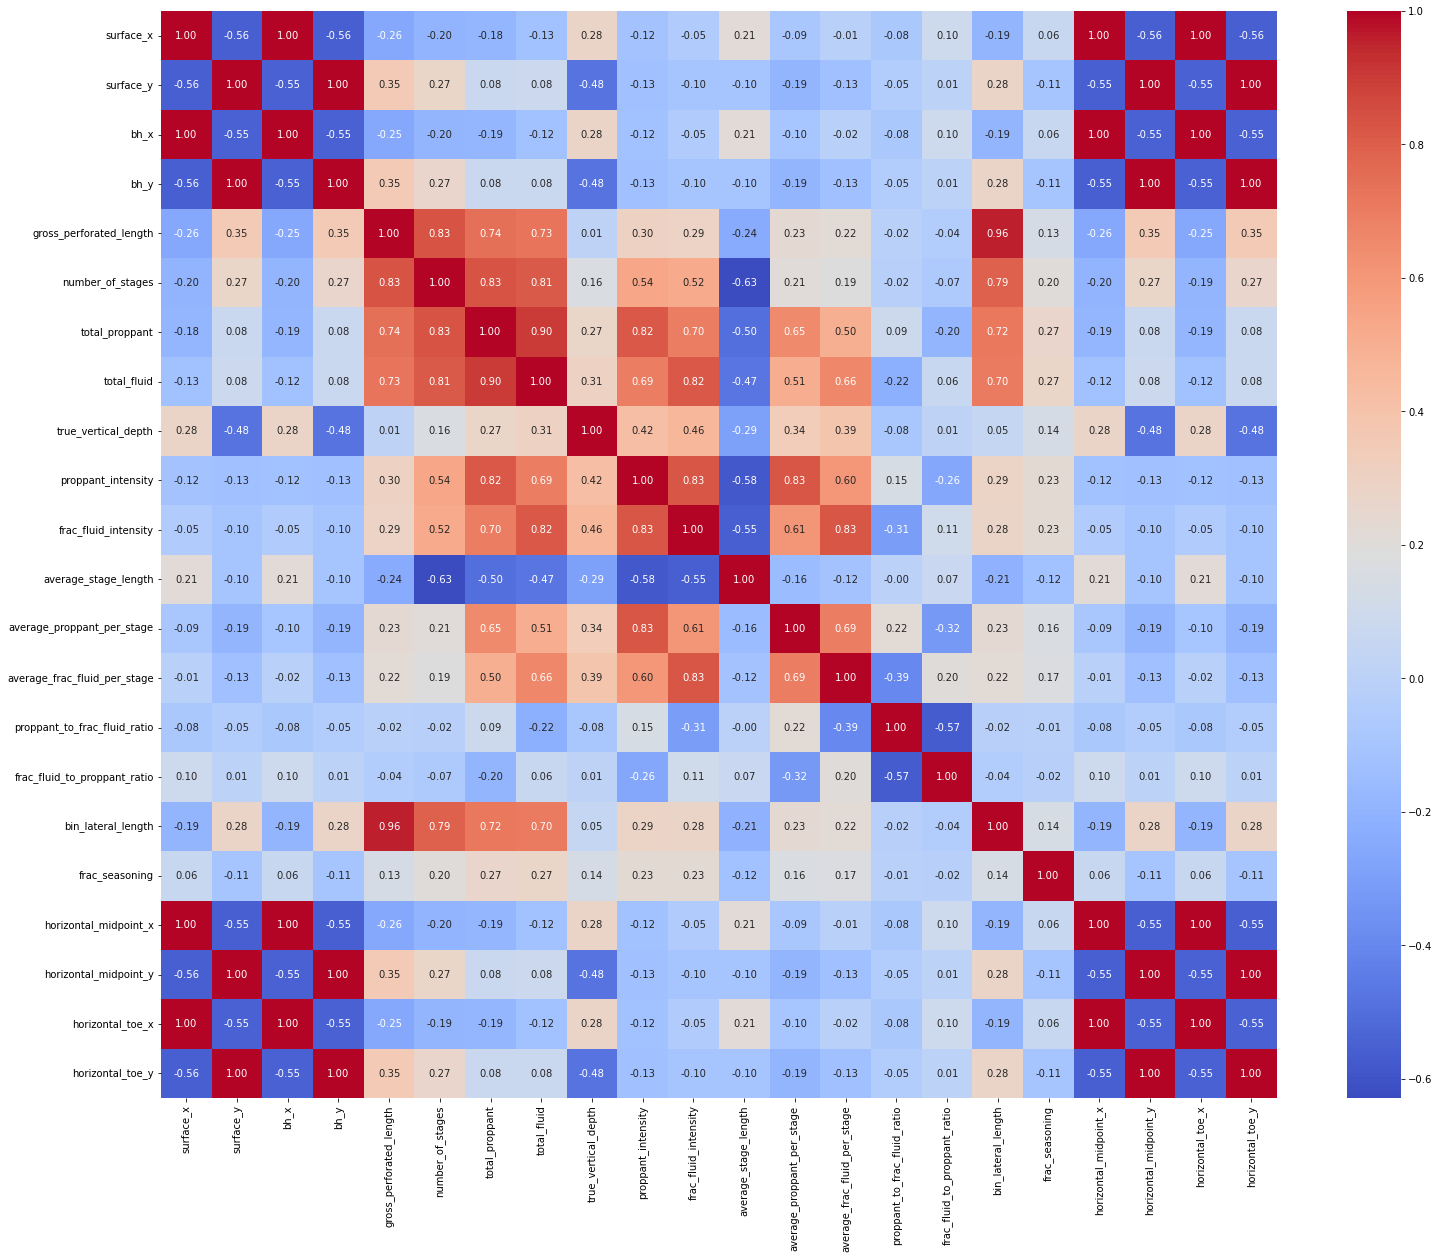

In [17]:
plt.figure(figsize=(25, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

Red indicates positive correlation, blue indicates negative correlation, and the intensity of the color corresponds to the strength of the correlation.

In this plot, "standardized_operator_name" has little correlation with most other variables, indicating that operator identity does not have a strong linear relationship with measured operational or production metrics.
The operational variables “gross_perforated_length”, “number_of_stages”, “total_proppant” and “total_fluid” show strong positive correlations with each other.

In [18]:
def scatterPlot3D(x1, x2, y):
    x = x1
    y = x2
    z = y
    plt.figure(figsize=(10, 8))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scat = ax.scatter(x, y, c=z, cmap='viridis_r', alpha=0.5, s=12)

    ax.set_xlabel('surface_x')
    ax.set_ylabel('surface_y')
    ax.set_zlabel('OilPeakRate')
    ax.view_init(elev=40., azim=150)

    fig.colorbar(scat, shrink=0.8, pad=0.2)
    plt.show()

<Figure size 720x576 with 0 Axes>

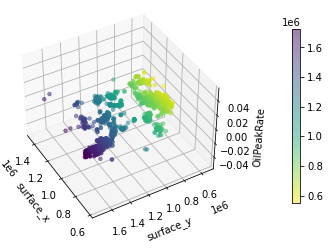

In [19]:
scatterPlot3D(X["surface_x"], X["surface_y"],Y)

According to the anonymized location of surface hole on the x-axis and y-axis, each point in the plot corresponds to a well. Points which are darker in color correspond to higher oil peak production rates.

The scatter plot points which form clusters, suggesting that there might be areas on the surface where the "OilPeakRate" is consistently higher or lower, helping to identify potential good spots for oil extraction.

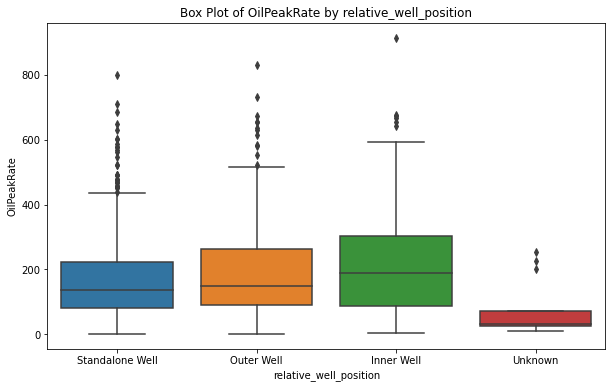

In [20]:
plt.figure(figsize=(10, 6))

data = pd.DataFrame({
    'relative_well_position': X['relative_well_position'],
    'OilPeakRate': Y
})
sns.boxplot(x='relative_well_position', y='OilPeakRate', data=data)

plt.xlabel('relative_well_position')
plt.ylabel('OilPeakRate')
plt.title('Box Plot of OilPeakRate by relative_well_position')

plt.show()

Box plot above displays the distribution of OilPeakRate across wells classified by their relative position: Standalone Well, Outer Well, Inner Well, and Unknown.
1. **Inner Wells**: Highest median OilPeakRate with less variability, indicating consistent high performance.
2. **Outer and Standalone Wells**: Moderate to high variability in OilPeakRate, reflecting diverse operational or geological factors.
3. **Unknown Category**: Lowest median OilPeakRate and tight distribution, suggesting generally poorer performance or incomplete data affecting assessment.

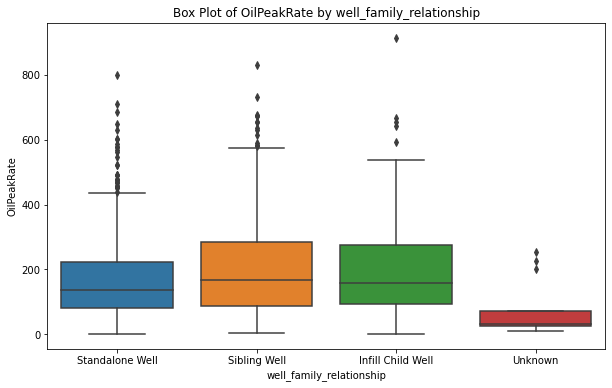

In [21]:
plt.figure(figsize=(10, 6))
data = pd.DataFrame({
    'well_family_relationship': X['well_family_relationship'],
    'OilPeakRate': Y
})
sns.boxplot(x='well_family_relationship', y='OilPeakRate', data=data)

plt.xlabel('well_family_relationship')
plt.ylabel('OilPeakRate')
plt.title('Box Plot of OilPeakRate by well_family_relationship')

plt.show()

In this figure, the consistency of sibling wells and infill child wells can provide more reliable production rates, which facilitates stable production forecasting and operational planning.
Standalone wells' boxes and whiskers are wider, indicating that their peak oil rates are less predictable and more dispersed.
High medians and wide variability among standalone wells may indicate greater odds of risk and reward.

# Feature Engineering

In [22]:
df.dtypes

surface_x                       float64
surface_y                       float64
bh_x                            float64
bh_y                            float64
gross_perforated_length         float64
number_of_stages                float64
total_proppant                  float64
total_fluid                     float64
true_vertical_depth             float64
ffs_frac_type                    object
proppant_intensity              float64
frac_fluid_intensity            float64
average_stage_length            float64
average_proppant_per_stage      float64
average_frac_fluid_per_stage    float64
proppant_to_frac_fluid_ratio    float64
frac_fluid_to_proppant_ratio    float64
bin_lateral_length              float64
relative_well_position           object
batch_frac_classification        object
well_family_relationship         object
frac_seasoning                  float64
horizontal_midpoint_x           float64
horizontal_midpoint_y           float64
horizontal_toe_x                float64


In [24]:
categorical_cols = [  'ffs_frac_type', 'relative_well_position', 'batch_frac_classification', 'well_family_relationship']
for col in categorical_cols:
    df[col] = df[col].astype('category')
df.dtypes

surface_x                        float64
surface_y                        float64
bh_x                             float64
bh_y                             float64
gross_perforated_length          float64
number_of_stages                 float64
total_proppant                   float64
total_fluid                      float64
true_vertical_depth              float64
ffs_frac_type                   category
proppant_intensity               float64
frac_fluid_intensity             float64
average_stage_length             float64
average_proppant_per_stage       float64
average_frac_fluid_per_stage     float64
proppant_to_frac_fluid_ratio     float64
frac_fluid_to_proppant_ratio     float64
bin_lateral_length               float64
relative_well_position          category
batch_frac_classification       category
well_family_relationship        category
frac_seasoning                   float64
horizontal_midpoint_x            float64
horizontal_midpoint_y            float64
horizontal_toe_x

In [25]:
df['horizontal_length'] = 2 * ((df['horizontal_toe_x'] - df['horizontal_midpoint_x']) ** 2 + (df['horizontal_toe_y'] - df['horizontal_midpoint_y']) ** 2) ** 0.5

## Handle Infinity Values

In [26]:
df['frac_fluid_to_proppant_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['frac_fluid_to_proppant_ratio'].fillna(df['frac_fluid_to_proppant_ratio'].mean(), inplace=True)

# Model Configuration

In [27]:
X = df.drop(['OilPeakRate'], axis=1)
y = df['OilPeakRate']
X.shape, y.shape

((1983, 27), (1983,))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape

((1487, 27), (496, 27))

## Preprocess: Encode Categorical Data and Normalization

In [29]:
numerical_cols = [col for col in X.columns if col not in categorical_cols]
# Create a pipeline for scaling numerical features
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])
# Create a pipeline for one-hot encoding categorical features
categorical_transformer = Pipeline(steps=[
    ('label', OneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)]
)

## Feature Selection

In [30]:
feature_selection_kbest = SelectKBest(mutual_info_regression, k=25)

## Build Pipeline

In [31]:
model = xgb.XGBRegressor(eval_metric='rmse', max_depth=8, n_estimators=1000, learning_rate=0.005)
b_model = BaggingRegressor(base_estimator=model, n_estimators=10, random_state=0, bootstrap=False)

The use of XGBoost in combination with BaggingRegressor leverages the high performance and accuracy of gradient boosting while enhancing stability and reducing overfitting through the aggregation of multiple, diverse models.

In [32]:
# Define a complete pipeline with preprocessing, feature selection, and the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection_kbest),
    ('model', b_model)
])

## Cross-validation

In [33]:
scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')

In [34]:
rmse_scores = np.sqrt(-scores)
print("RMSE scores for each fold:", rmse_scores)
print("Average RMSE:", np.mean(rmse_scores))

RMSE scores for each fold: [141.59250955  63.07545238  94.6356261  102.44728884  84.90483191]
Average RMSE: 97.33114175719027


## Model Training

In [35]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['surface_x', 'surface_y',
                                                   'bh_x', 'bh_y',
                                                   'gross_perforated_length',
                                                   'number_of_stages',
                                                   'total_proppant',
                                                   'total_fluid',
                                                   'true_vertical_depth',
                                                   'proppant_intensity',
                                                   'frac_fluid_intensity',
                                                   'average_stage_length',
                      

## Model Testing

In [36]:
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 74.55716568181602


# Scoring Testing

In [37]:
test_df = pd.read_csv('Test/scoring.csv')
test_df.head()

,Unnamed: 0,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,number_of_stages,total_proppant,total_fluid,...,pad_id,relative_well_position,batch_frac_classification,well_family_relationship,frac_type,frac_seasoning,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y
0,29437,947147.1748,1035962.615,953396.0947,1032855.270,1018,6370.078740,13.0,360142.8571,2049015.067,...,112159,Outer Well,Non-Batch Frac,Sibling Well,Primary Frac,60.0,950652.9334,1034227.679,953396.7299,1032858.035
1,29438,955677.5229,1046163.699,950265.0303,1048815.456,1018,5244.094488,13.0,376714.2857,1876123.612,...,103362,Standalone Well,Non-Batch Frac,Standalone Well,Primary Frac,6.0,952697.5169,1047650.652,950263.6479,1048816.415
2,29439,954696.7455,1045332.222,948091.9154,1048609.702,1018,6694.881890,13.0,438285.7143,2773869.727,...,109543,Outer Well,Non-Batch Frac,Infill Child Well,Primary Frac,29.0,951017.5174,1047161.324,948094.3009,1048611.380
3,29441,958031.7779,1040111.409,948091.9154,1048609.702,1018,6694.881890,13.0,438285.7143,2773869.727,...,104643,Standalone Well,Unknown,Standalone Well,Primary Frac,29.0,959098.6304,1039881.055,959379.3218,1039778.224
4,29442,967972.6000,1038411.501,964095.0748,1040346.080,1018,2520.669291,13.0,273857.1429,1340587.457,...,107027,Standalone Well,Unknown,Standalone Well,Primary Frac,29.0,965562.2003,1039613.686,964095.1690,1040346.493


In [38]:
test_df.drop(['Unnamed: 0', 'pad_id', 'standardized_operator_name', 'frac_type'], axis=1, inplace=True)
test_df.describe()

,surface_x,surface_y,bh_x,bh_y,gross_perforated_length,number_of_stages,total_proppant,total_fluid,true_vertical_depth,proppant_intensity,...,average_proppant_per_stage,average_frac_fluid_per_stage,proppant_to_frac_fluid_ratio,frac_fluid_to_proppant_ratio,bin_lateral_length,frac_seasoning,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y
count,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,400.000000,400.000000,4.000000e+02,4.000000e+02,400.000000,400.000000,...,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02
mean,1.265688e+06,9.578735e+05,1.264045e+06,9.566635e+05,5317.726378,20.155000,4.289291e+05,2.421779e+06,7452.656490,78.256537,...,15442.396648,114711.696686,0.192060,5.966958,1.156250,56.395000,1.265714e+06,9.578447e+05,1.265730e+06,9.578100e+05
std,2.440794e+05,3.452532e+04,2.448280e+05,3.370755e+04,1700.482379,12.952234,4.271167e+05,2.542281e+06,2978.267950,68.316997,...,8668.372366,64708.751312,0.132087,2.270399,0.355707,39.173337,2.444750e+05,3.451564e+04,2.448223e+05,3.455319e+04
min,9.154024e+05,9.106390e+05,9.085551e+05,9.084477e+05,1512.795276,4.000000,4.830357e+03,1.085000e+03,4482.283465,3.193001,...,966.071429,3146.500487,0.038368,0.401977,0.000000,0.000000,9.123525e+05,9.094204e+05,9.085936e+05,9.084858e+05
25%,9.671395e+05,9.348638e+05,9.663269e+05,9.354920e+05,4274.360236,10.000000,1.658571e+05,8.327415e+05,5190.698819,30.524091,...,9042.492857,66532.468630,0.141377,4.527046,1.000000,29.000000,9.704786e+05,9.349330e+05,9.696014e+05,9.346262e+05
50%,1.439764e+06,9.462202e+05,1.438885e+06,9.467147e+05,4670.275591,13.000000,2.286429e+05,1.258685e+06,5256.397638,45.204307,...,10854.857140,82832.884690,0.176222,5.674647,1.000000,45.000000,1.440445e+06,9.467371e+05,1.438989e+06,9.468593e+05
75%,1.460374e+06,9.656596e+05,1.461996e+06,9.607632e+05,6694.881890,30.000000,5.372857e+05,3.088523e+06,11467.765752,115.032439,...,21058.185330,158964.972500,0.220895,7.073284,1.500000,76.250000,1.463601e+06,9.653844e+05,1.464275e+06,9.654766e+05
max,1.549970e+06,1.072597e+06,1.555811e+06,1.074960e+06,10019.685040,56.000000,2.151286e+06,1.276079e+07,12553.149610,523.773373,...,38500.000000,304803.450700,2.487702,26.063354,2.000000,176.000000,1.553450e+06,1.073896e+06,1.556927e+06,1.074960e+06


In [39]:
for col in categorical_cols:
    try:
        test_df[col] = test_df[col].astype('category')
    except KeyError:
        pass

In [40]:
test_df['horizontal_length'] = 2 * ((test_df['horizontal_toe_x'] - test_df['horizontal_midpoint_x']) ** 2 + (test_df['horizontal_toe_y'] - test_df['horizontal_midpoint_y']) ** 2) ** 0.5

In [41]:
y_pred = pipeline.predict(test_df)

In [43]:
y_pred

array([130.40858 , 136.29002 , 140.6162  , 122.55727 , 121.92953 ,
       188.76195 ,  75.78009 , 162.01396 , 143.7975  , 132.95186 ,
       128.1194  , 154.12144 ,  82.22793 ,  88.29552 , 289.8079  ,
       129.46227 ,  74.018196, 106.62889 ,  50.152645, 195.45688 ,
        68.49577 , 197.00038 , 183.53102 , 312.7747  , 241.65353 ,
        63.1764  , 261.4499  , 329.3005  , 243.23392 , 254.49812 ,
       205.38113 , 140.54152 , 127.49831 ,  97.83946 , 104.92778 ,
       282.36154 ,  87.50303 , 239.43303 , 207.01639 , 284.90082 ,
       241.3334  , 301.4653  , 229.44986 , 304.38223 , 229.45462 ,
       363.10864 , 417.3017  , 304.84415 , 263.27872 , 238.84384 ,
       336.6701  , 308.47214 , 435.4167  , 177.70982 , 254.48416 ,
       312.61008 , 103.87489 , 262.4204  , 312.9555  , 106.434616,
       291.23117 ,  73.54511 , 268.32867 , 199.13004 , 221.67014 ,
       275.70087 , 226.22165 , 240.95798 ,  77.189896,  77.30645 ,
       263.6806  , 222.51212 , 224.90518 , 120.28507 , 283.408

In [44]:
pd.DataFrame(y_pred, columns=['OilPeakRate']).to_csv('Test/submission.csv', index=False)